In [17]:
from clrs._src.algorithms.graphs import bfs

In [18]:
import numpy as np
import networkx as nx

In [42]:
# genearte random er graph
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p)

# get the adjacency matrix
A = nx.to_numpy_array(G)

In [43]:
print(A)

[[0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]


In [44]:
# apply bfs
s = 0
pi, probes = bfs(A, s)

In [51]:
pi

array([0, 0, 5, 0, 3, 0, 9, 2, 3, 0])

In [52]:
probes

{'input': {'node': {'pos': {'data': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'type_': 'scalar'},
   's': {'data': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'type_': 'mask_one'}},
  'edge': {'A': {'data': array([[0., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
           [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
           [1., 1., 0., 0., 1., 1., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
           [1., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
           [1., 0., 0., 0., 1., 1., 1., 0., 0., 0.]]),
    'type_': 'scalar'},
   'adj': {'data': array([[1., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
           [1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
           [1., 1., 0., 1., 1., 1., 0

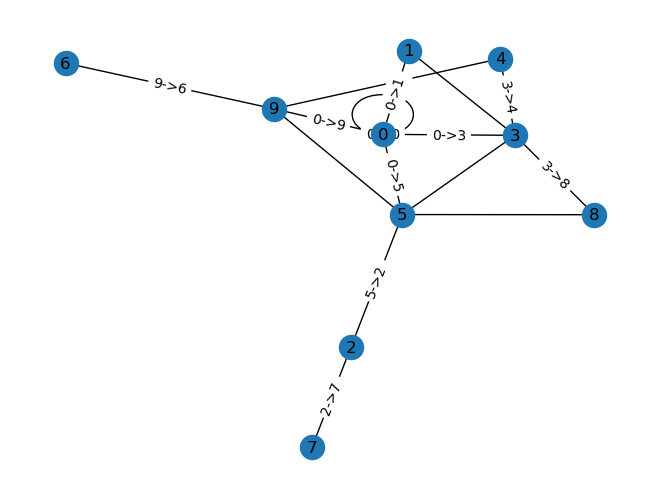

In [64]:
def visualize_bfs_tree(A, pi):
    G = nx.from_numpy_array(A)
    edges = [(pi[i], i) for i in range(len(pi)) if pi[i] != -1]
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(pi[i], i): f'{pi[i]}->{i}' for i in range(len(pi)) if pi[i] != -1})
    return G

visualize_bfs_tree(A, pi)

In [ ]:
[0, 0, 5, 0, 3, 0, 9, 2, 3, 0]
